# Insights of Markov Chain Monte Carlo via the Gamma-Poisson Model

## Today's Learning Objectives

1. Describe the Gamma-Poisson model via the Bayes' rule.
2. Describe the Monte Carlo algorithm.
3. Describe a Markov Chain.
4. Explain an overview of MCMC via the Bayes’ rule.
5. Apply MCMC via the Metropolis-Hastings algorithm.
6. Apply MCMC via the Metropolis algorithm.
7. Practice `R` coding of the MCMC via the Metropolis algorithm with a Gamma-Poisson example.

## Loading `R` Packages

In [1]:
options(repr.matrix.max.rows = 15)
library(bayesrules)
library(tidyverse)
library(cowplot)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘cowplot’




The following object is masked from ‘package:lubridate’:

    stamp




## 1.  Gamma-Poisson and Bird Count Data

Firstly, we will explore another foundational Bayesian model called **Gamma-Poisson**. As in the case of the **Beta-Binomial** model from {doc}`lecture3_beta_binomial_Bayesian_modelling`, the Gamma-Poisson model can be solved analytically to obtain the exact posterior distribution of our parameter of interest, i.e., using Markov Chain Monte Carlo (MCMC) to get an approximate posterior distribution is unnecessary **in practice**. Nevertheless, **we will do it in this tutorial to verify that MCMC actually works via the Metropolis algorithm**.

```{attention}
Note we will repeat this same **proof of concept** for the Gamma-Poisson model in `worksheet2`, but via `Stan` with the [**No-U-Turn sampler (NUTS)**](https://www.jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf) algorithm.
```

We will use two common distributions: the continuous [**Gamma**](https://ubc-mds.github.io/DSCI_551_stat-prob-dsci/notes/appendix-dist-cheatsheet.html#gamma) and the discrete [**Poisson**](https://ubc-mds.github.io/DSCI_551_stat-prob-dsci/notes/appendix-dist-cheatsheet.html#poisson). Again, each distribution will play a crucial role in this inferential process (**via the Bayes' rule!**). That said, keep the Bayes' rule in mind for the Gamma-Poisson model:

$$\text{posterior} \propto \text{prior} \times \text{likelihood}.$$

Thus, in this framework, we need to define the specific **prior** and **likelihood** to get the **posterior** of our population parameter of interest.

### 1.1. The Likelihood

Our gathered evidence will be an *independent and identically distributed (iid)* random sample of size $n$ coming from a Poisson population with a **continuous parameter $\lambda > 0$**.

Therefore, for the $i$th element, the probability mass function (PMF) is the following:

$$f(y_i \mid \lambda) = \frac{\lambda^{y_i} \exp(-\lambda)}{y_i!} \qquad \text{for } i = 1, \dots, n.$$

Let us define a vector of our gathered evidence such that $\mathbf{y} = (y_1, \dots, y_n)^T$. Therefore, the likelihood function (which is **mathematically** equal to the joint PMF) is

```{math}
\begin{align*}
l(\lambda \mid \mathbf{y})& = f(\mathbf{y} \mid \lambda) \\ 
&= \prod_{i = 1}^n \frac{\lambda^{y_i} \exp(-\lambda)}{y_i!} \\
&= \frac{\lambda^{\sum_{i = 1}^n y_i} \exp(-n\lambda)}{\prod_{i = 1}^n y_i!}.
\end{align*}
```

### 1.2. The $\lambda$ Prior

Moving along with this model, note we have the following **likelihood**:

$$Y_i \mid \lambda \mathop\sim^\text{iid} \text{Poisson}(\lambda) \quad \text{for } i = 1, \dots, n.$$

```{attention}
The previous equation is **conditioning** $Y_i$ on $\lambda$. Recall one of the most critical characteristics of Bayesian thinking is that **population parameters are not fixed anymore but RANDOM**.
```

The Gamma-Poisson would need a **prior** distribution for $\lambda > 0$ (our parameter of interest). Note that $\lambda$ should be nonnegative, thus we need to find a distribution with the **right support** (i.e., a proper range of plausible values).

A suitable choice for the **continuous** prior distribution of $\lambda$ is the Gamma distribution. Hence, the prior distribution can be:

$$\lambda \sim \text{Gamma}(s, r).$$

Its probability density function (PDF) is:

$$f(\lambda) = \frac{r^s}{\Gamma(s)} \lambda^{s - 1} \exp(-r \lambda) \quad \text{for } \lambda > 0,$$

where $\Gamma(\cdot)$ is the Gamma function. Moreover, the **shape** and **rate** parameters $s > 0$ and $r >0$ (respectively) are called **hyperparameters**.

```{attention}
The [**cheatsheet**](https://ubc-mds.github.io/DSCI_551_stat-prob-dsci/notes/appendix-dist-cheatsheet.html#gamma) has $x$ as a variable in the Gamma's PDF instead of $\lambda$. Therefore, we are adapting the above PDF notation to the context of our problem. Moreover, we are reparameterizing the PDF with $s = k$ and $r = 1 / \theta$.
```

### 1.3. The Bayes' Rule in Action 

We already have our Gamma **prior** and Poisson **likelihood**. It is time to apply the Bayes' rule as follows:

$$
\text{posterior} \propto \text{prior} \times \text{likelihood}
$$

$$
\overbrace{f(\lambda \mid \mathbf{y})}^{\text{Posterior}} \propto \overbrace{f(\lambda)}^{\text{Prior}} \times \overbrace{l(\lambda \mid \mathbf{y})}^{\text{Likelihood}}
$$

$$
\underbrace{f(\lambda \mid \mathbf{y})}_{\text{Posterior}} \propto \underbrace{\frac{r^s}{\Gamma(s)} \lambda^{s - 1} \exp(-r \lambda)}_{\text{Prior}} \times \underbrace{\frac{\lambda^{\sum_{i = 1}^n y_i} \exp(-n\lambda)}{\prod_{i = 1}^n y_i!}}_{\text{Likelihood}}.
$$

We can get rid of all the terms that **DO NOT** depend on $\lambda$ on the right-hand side (under our inferential Bayesian framework, **they are viewed as constants!**):

$$
f(\lambda \mid \mathbf{y}) \propto \lambda^{s - 1} \exp(-r \lambda) \lambda^{\sum_{i = 1}^n y_i} \exp(-n\lambda) = \lambda^{\left( s + \sum_{i = 1}^n y_i \right) - 1} \exp [-(r + n) \lambda].
$$

```{attention}
We are just grouping exponents by common bases in the above equation.
```

This result gives us **an interesting insight for the posterior distribution of $\lambda$**:

$$
f(\lambda \mid \mathbf{y}) \propto \underbrace{\lambda^{(s + \sum_{i = 1}^n y_i) - 1} \exp [-(r + n) \lambda]}_{\text{Kernel of a Gamma}\left( s + \sum_{i = 1}^n y_i, r + n \right)}.
$$

This expression is what we call a **kernel** of a $\text{Gamma} \left( s + \sum_{i = 1}^n y_i, r + n \right)$.

```{important}
A kernel is the part of a given PDF that **DOES DEPEND** on our parameter of interest! The $\propto$ symbol allows us to conclude this matter.
```

Hence, we just obtained **the exact posterior of $\lambda$**:

$$f(\lambda \mid \mathbf{y}) = \overbrace{\frac{(r + n)^{s + \sum_{i = 1}^n y_i}}{\Gamma \left( s + \sum_{i = 1}^n y_i \right)}}^{\text{Does not depend on $\lambda$}} \lambda^{\left( s + \sum_{i = 1}^n y_i \right) - 1} \exp [-(r + n) \lambda].$$

### 1.4. A Practical Case Involving the Gamma-Poisson Model

Our Gamma-Poisson model is defined as follows:

```{math}
\begin{align*}
\text{likelihood:} \qquad Y_i = y_i \mid \lambda \mathop\sim^\text{iid} \text{Poisson}(\lambda) \quad \text{for } i = 1, \dots, n \\
\text{prior:} \quad \lambda \sim \text{Gamma}(s, r),
\end{align*}
```

where **the exact posterior for $\lambda$** is

$$\lambda \mid \mathbf{Y} = \mathbf{y} \sim \text{Gamma} \left( s + \sum_{i = 1}^n y_i, r + n \right).$$

Now, let us apply this Bayesian model. We will use the dataset `bird_counts` from the `bayesrules` package.

```{admonition} Description of the Bird Counts Data
:class: hint
The description of `bird_counts` is the following:

> *Bird count data collected between the years 1921 and 2017, in late December, by birdwatchers in the Ontario, Canada area. The data was made available by the Bird Studies Canada website and distributed through the R for Data Science TidyTuesday project.*
```

**Suppose you want to make Bayesian inference on the mean `count` $\lambda$ of [belted kingfishers](https://en.wikipedia.org/wiki/Belted_kingfisher) in Ontario, Canada area.** Hence, the below code obtains our `observed_evidence` in column `count` $\mathbf{y} = (y_1, \dots, y_n)^T$. 

In [2]:
observed_evidence <- bird_counts |>
  filter(species == "Belted Kingfisher") |>
  select(year, species, count)

observed_evidence

year,species,count
<dbl>,<chr>,<dbl>
1921,Belted Kingfisher,0
1922,Belted Kingfisher,0
1924,Belted Kingfisher,0
1925,Belted Kingfisher,0
1926,Belted Kingfisher,0
1928,Belted Kingfisher,0
1930,Belted Kingfisher,0
1931,Belted Kingfisher,0
⋮,⋮,⋮


```{caution}
Of course, there should be a correlation structure across the years, and we could use a **Bayesian hierarchical count regression model**. Nevertheless, that topic is out of the scope of this worksheet (we will cover hierarchical models in the fourth week of this block). Thus, let us assume the observations are independent.
```

Once we have our `observed_evidence`, note that:

```{math}
\begin{gather*}
\sum_{i = 1}^n y_i = 396 \\
n = 94.
\end{gather*}
```

In [3]:
sum(observed_evidence$count)


[1] 396

In [4]:
nrow(observed_evidence)

[1] 94

Suppose we assume the following prior for $\lambda$:

$$\lambda \sim \text{Gamma}(s = 150, r = 40).$$

Thus, the exact posterior of $\lambda$ is:

$$\lambda \mid \mathbf{Y} = \mathbf{y} \sim \text{Gamma} \left( s + \sum_{i = 1}^n y_i = 546, r + n = 134 \right).$$

We use the function `plot_beta_binomial()` from `bayesrules` to plot the prior, likelihood, and posterior:

In [5]:
options(repr.plot.height = 8, repr.plot.width = 12)

gamma_poisson_birds <- plot_gamma_poisson(shape = 150, rate = 40, sum_y = sum(observed_evidence$count), 
  n = nrow(observed_evidence))  +
  labs(y = "Density") +
  ggtitle("Comparison of Prior, Likelihood, and Posterior") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.text = element_text(size = 21, margin = margin(r = 1, unit = "cm")),
  )

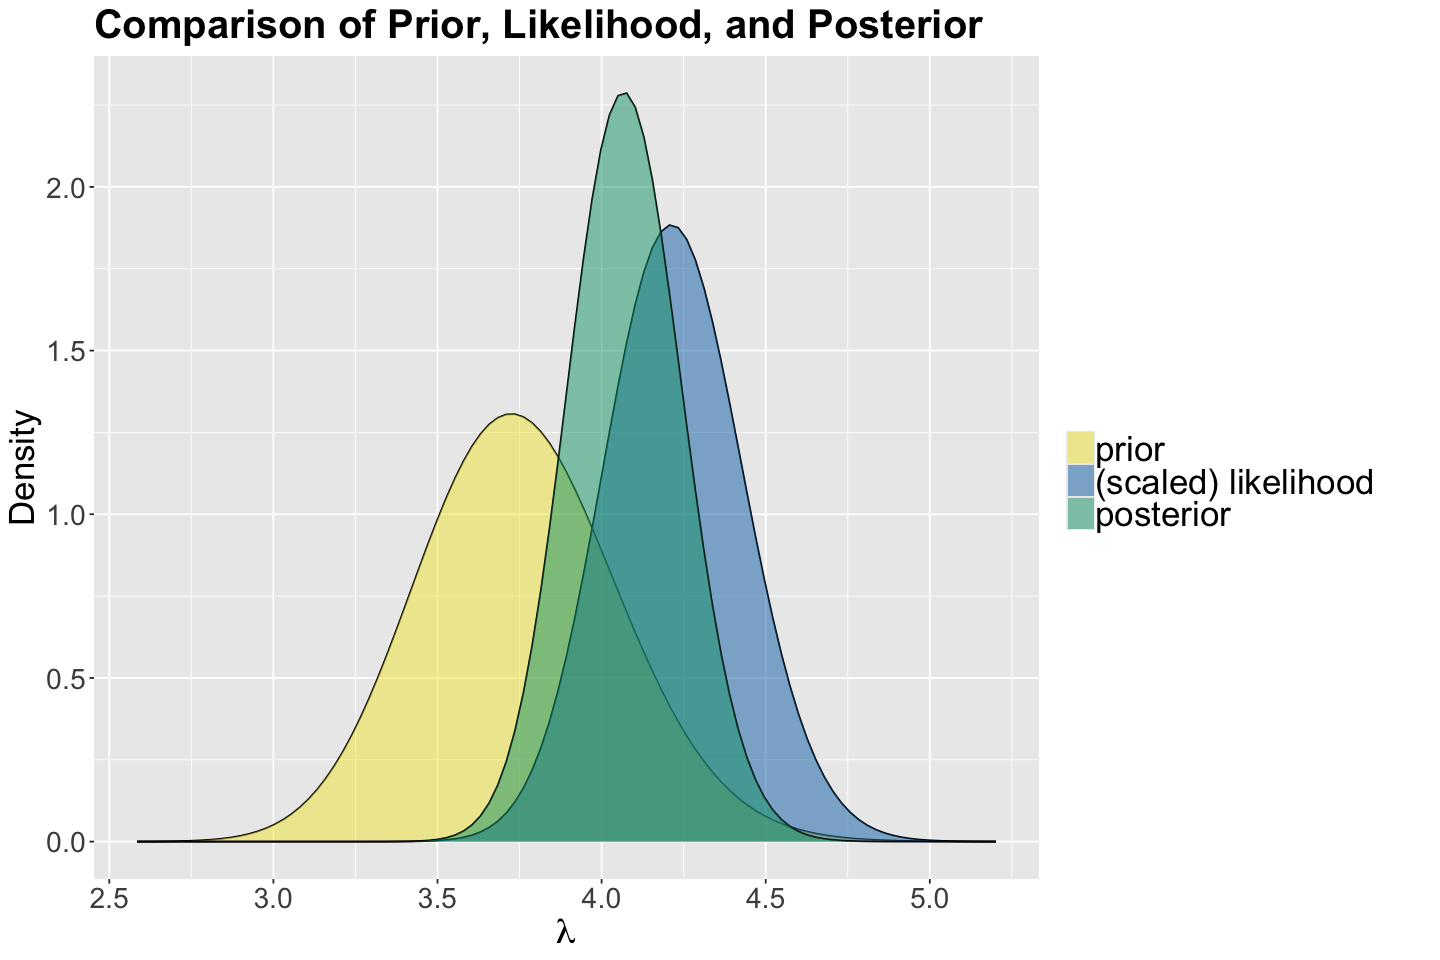

In [6]:
gamma_poisson_birds

Once we have worked with the exact Gamma posterior of $\lambda$, **let us check whether we can obtain a decent approximation via Markov Chain Monte Carlo (MCMC)**.

## 2. Overview of Markov Chain Monte Carlo

**In general**, a Bayesian model will have $d$ parameters of interest for which we will need to obtain a **joint posterior distribution**:

$$\Theta = (\theta_1, \dots, \theta_d)^T.$$

Recall the Bayes' rule:

$$\text{posterior} = \frac{\text{prior} \times \text{likelihood}}{\text{normalizing constant}} \propto \text{prior} \times \text{likelihood}.$$

Using $\Theta$ as our parameter **vector** of interest, let $f(\Theta)$ be the **multivariate** joint prior. 

Moreover with our observed data $\mathbf{y} = (y_1, \dots, y_n)^T$, let $\mathscr{l}(\Theta \mid \mathbf{y})$ be the corresponding **multivariate** likelihood function along with the **multivariate** normalizing constant $f(\mathbf{y})$. 

Then, for the **multivariate** joint posterior $f(\Theta \mid \mathbf{y})$, the Bayes' rule becomes:

$$f(\Theta \mid \mathbf{y}) = \frac{f(\Theta) \times \mathscr{l}(\Theta \mid \mathbf{y})}{f(\mathbf{y})} \propto f(\Theta) \times \mathscr{l}(\Theta \mid \mathbf{y}).$$

Why are we highlighting **multivariate** all the time? It is because we have $d$ parameters in vector $\Theta$. 

Suppose we want to obtain an **analytical** form for $f(\mathbf{y})$, then this will be an integral to solve:

$$f(\mathbf{y}) = \int_{\theta_1} \int_{\theta_2} \cdots \int_{\theta_d} f(\Theta) \mathscr{l}(\Theta \mid \mathbf{y}) d\theta_d\ \cdots d\theta_1.$$

Solving this multivariate integral looks pretty challenging! Nonetheless, recall we do not need to obtain $f(\mathbf{y})$, but we still need to work around the math in

$$f(\Theta \mid \mathbf{y}) \propto f(\Theta) \times \mathscr{l}(\Theta \mid \mathbf{y}).$$

Let us explore the MCMC algorithm by parts: **Markov Chain** and **Monte Carlo**.

### 2.1. Monte Carlo Algorithm

Suppose you have a closed analytical form for the posterior distribution $f(\Theta \mid \mathbf{y})$. You can build your **independent** Monte Carlo sample $\{ \Theta_1, \dots, \Theta_N \}$ of size $N$, from $f(\Theta \mid \mathbf{y})$ by selecting each element $\Theta_i$ ($i = 1, \dots, N$) in the following way:

- **Step 1.** Draw $\Theta_i$ from $f(\Theta \mid \mathbf{y})$.
- **Step 2.** Go there.

```{attention}
Drawing **fully independent** elements for our sample **WILL NOT** be possible in MCMC. Moreover, **note that $n \neq N$**. The term $n$ refers to your sampled data size in the **likelihood**, whereas the $N$ refers to the number of draws $\Theta_i$ in the simulation.
```

### 2.2. Markov Chain

Here comes the MCMC twist to the previous Monte Carlo approach: **Markov Chain**.

```{admonition} What is a Markov Chain?
:class: hint
In terms of our Bayesian modelling for the posterior, it is a sequence $\{ \Theta_1, \dots, \Theta_N \}$ of size $N$ whose elements are **NOT ENTIRELY INDEPENDENT** (hence the word **chain**!).
```

**What does NOT ENTIRELY INDEPENDENT implicate?** It implicates the so-called **Markov property**: 

> *The next sampled $\Theta_{i + 1}$ will depend on the current $\Theta_{i}$ but not on previous $\Theta_{i - 1}, \Theta_{i - 2}, \dots$*

More formally, because of this property, the conditional probability function of $\Theta_{i + 1}$ can be depicted as:

$$f(\Theta_{i + 1} \mid \Theta_{i}, \mathbf{y}) = f(\Theta_{i + 1} \mid \Theta_1, \Theta_2, \dots \Theta_{i}, \mathbf{y}).$$

```{important}
**There is no free lunch here!** Each element in this chain can be drawn **from another distribution and not specifically from our target posterior $f(\Theta \mid \mathbf{y})$**:

$$f(\Theta_{i + 1} \mid \Theta_{i}, \mathbf{y}) \neq f(\Theta_{i + 1} \mid \mathbf{y}).$$

Thus, what is the point of this Markov Chain approach? The answer lies in the MCMC algorithm that approximates $f(\Theta \mid \mathbf{y})$ via our $N$ elements in the chain. 

**There is more than one MCMC algorithm to do so, and the foundational one is the Metropolis-Hastings algorithm.**
```

<img src="https://upload.wikimedia.org/wikipedia/commons/a/a6/3dRosenbrock.png" alt="Dinosaur" />
<br>
<br>

Let us check **the plot above** (source: [*Wikipedia*](https://upload.wikimedia.org/wikipedia/commons/a/a6/3dRosenbrock.png)) to explain the conceptual intuition behind MCMC:

- Suppose you have a standalone parameter of interest whose whole space is depicted as the entire black square.
- You will use a **given algorithm** to perform your MCMC simulations. There is more than one choice of algorithm you could use (e.g., Metropolis-Hastings, Metropolis, [**Gibbs Sampling**](https://www.geeksforgeeks.org/what-is-gibbs-sampling/), [**No-U-Turn sampler NUTS**](https://www.jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf), etc). The global ideas in the upcoming bullet points remain for any algorithm.
- Three Markov chains start on the right-hand side of the parameter space: chain 1 (in yellow), chain 2 (in green), and chain 3 (in blue). 
- The region of **the correct posterior distribution of your parameter of interest** is shown on the left-hand side of the parameter space as **a well-defined diagonal region**. Moreover, the star indicates the maximum of this correct posterior distribution.
- Note that on the right-hand side, their corresponding states (i.e., links in the chains) are shown as dots with the same chain colour (either yellow, green or blue). These states correspond to the warmup period of the given algorithm (i.e., these warmup chain states allow the given algorithm to **learn** its way to the **well-defined diagonal region** on the left-hand side).
- The three chains have a random start on the right-hand side of the parameter space that might be closer or further away from the **well-defined diagonal region** on the left-hand side. This fact is based on what initial random value we use to start simulating from the corresponding chain. Note that chain 1 (in yellow) begins further away but eventually learns its way to the **well-defined diagonal region**.
- If we move from right to left in the parameter space, we will notice that the three chains start heading to the **well-defined diagonal region**. This fact is called: *the chains start mixing*.
- As we move more to the left to the **well-defined diagonal region**, the chain states (i.e., the dots) start getting coloured in red. These states correspond to the corresponding **post-warmup period** per chain. At the end of the day, these are the posterior samples (per chain!) you will have as the output of the MCMC simulation per chain.
- For the three chains and using a given MCMC algorithm in this plot, we can conclude that we converge to **the correct posterior distribution of your parameter of interest**.
- Finally, it is essential to remark that all chain states (i.e., the dots in the lines) are obtained by applying the Bayes' rule through different iterations of a given algorithm.

### 2.3. The Metropolis-Hastings Algorithm

This is one of the possible algorithms that will allow us to obtain **an approximation of the posterior distribution $f(\Theta \mid \mathbf{y})$** via our Markov Chain $\{ \Theta_1, \dots, \Theta_N \}$.

Hence, with $\Theta_i$ in our current iteration $(i = 1, 2, \dots, N - 1)$, the next iteration $\Theta_{i + 1}$ will be selected through a two-step process.

Recall the Bayes' rule:

$$f(\Theta \mid \mathbf{y}) \propto f(\Theta) \times \mathscr{l}(\Theta \mid \mathbf{y}).$$

Let the current $\Theta_i = \Theta$. Then, the algorithm's two steps are: 

- **Step 1.** Randomly draw a new location $\Theta'$ from a proposed model with probability density function (PDF) $q(\Theta' \mid \Theta)$. This proposed model is what we call a **jumping distribution** and it could be a **Uniform** or **Normal** which are symmetric.

```{attention}
Another choice of a jumping distribution could be **asymmetric**, such as the **Log-normal**. We can choose this jumping distribution class when there are **constraints** on our parameters of interest (e.g., they are nonnegative), or **we want to sample large values from the chain** (recall the Log-normal is a heavy-tailed distribution).
```

```{admonition} Why are the jumping Normal and Uniform distributions called symmetric?
:class: tip

Let us check a couple of PDFs with specific parameters (**just to explain why they are called symmetric**). Their corresponding means are indicated as vertical dashed red lines. This **symmetric** characteristic refers to the fact that these distributions have the same form on the right and left-hand sides of their corresponding means.
```

In [7]:
std_normal <- ggplot() +
  xlim(-5, 5) +
  ylim(0, 0.5) +
  geom_function(fun = dnorm, args = list(mean = 0, sd = 1), linewidth = 1) +
  geom_vline(xintercept = 0, colour = "darkred", linetype = "dashed", linewidth = 1) +
  theme(
    plot.title = element_text(size = 21, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
  ) +
  labs(y = "Density", x = expression(theta)) +
  ggtitle("Example of a Jumping Normal(0, 1)")

uniform_0_1 <- ggplot() +
  xlim(-0.5, 1.5) +
  ylim(0, 1.2) +
  geom_function(fun = dunif, args = list(min = 0, max = 1), linewidth = 1) +
  geom_vline(xintercept = 0.5, colour = "darkred", linetype = "dashed", linewidth = 1) +
  theme(
    plot.title = element_text(size = 21, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
  ) +
  labs(y = "Density", x = expression(theta)) +
  ggtitle("Example of a Jumping Uniform(0, 1)")

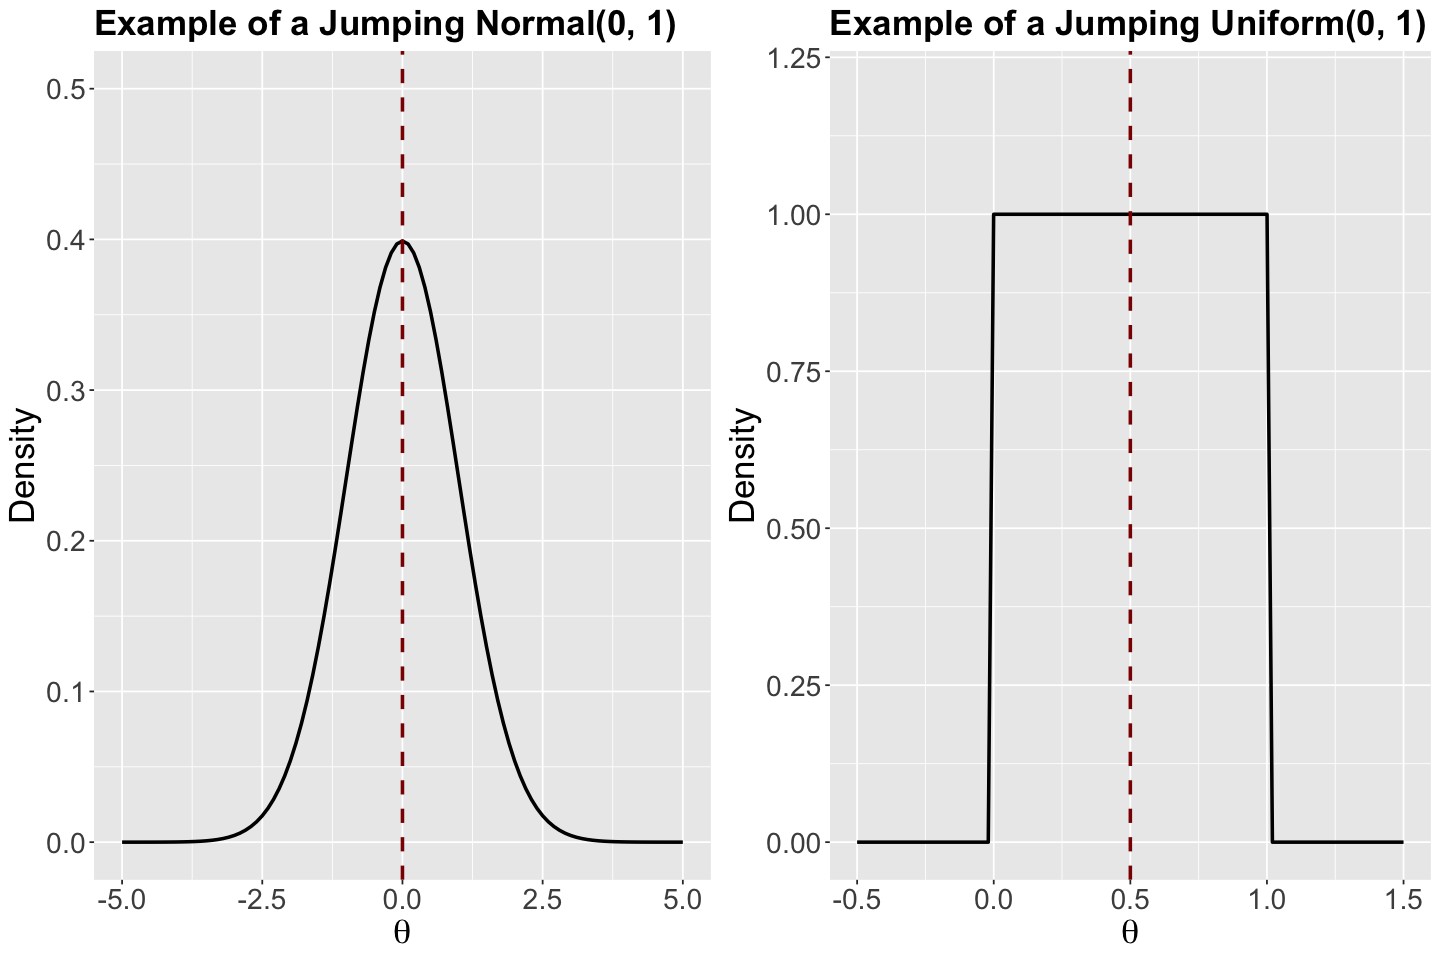

In [8]:
plot_grid(std_normal, uniform_0_1)

```{admonition} Why is the jumping Log-normal distribution called asymmetric?
:class: tip

Let us check the PDF with specific parameters (**just to explain why it is called asymmetric**). Its corresponding mean is indicated as a vertical dashed red line. This **asymmetric** characteristic refers to the distribution having different forms on the right and left-hand sides of its corresponding mean.
```

In [9]:
lognormal <- ggplot() +
  xlim(0, 8) +
  ylim(0, 0.75) +
  geom_function(fun = dlnorm, args = list(meanlog = 0, sdlog = 1), linewidth = 1) +
  geom_vline(xintercept = exp(0.5), colour = "darkred", linetype = "dashed", linewidth = 1) +
  theme(
    plot.title = element_text(size = 21, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
  ) +
  labs(y = "Density", x = expression(theta)) +
  ggtitle("Example of a Jumping Lognormal(0, 1) Distribution")

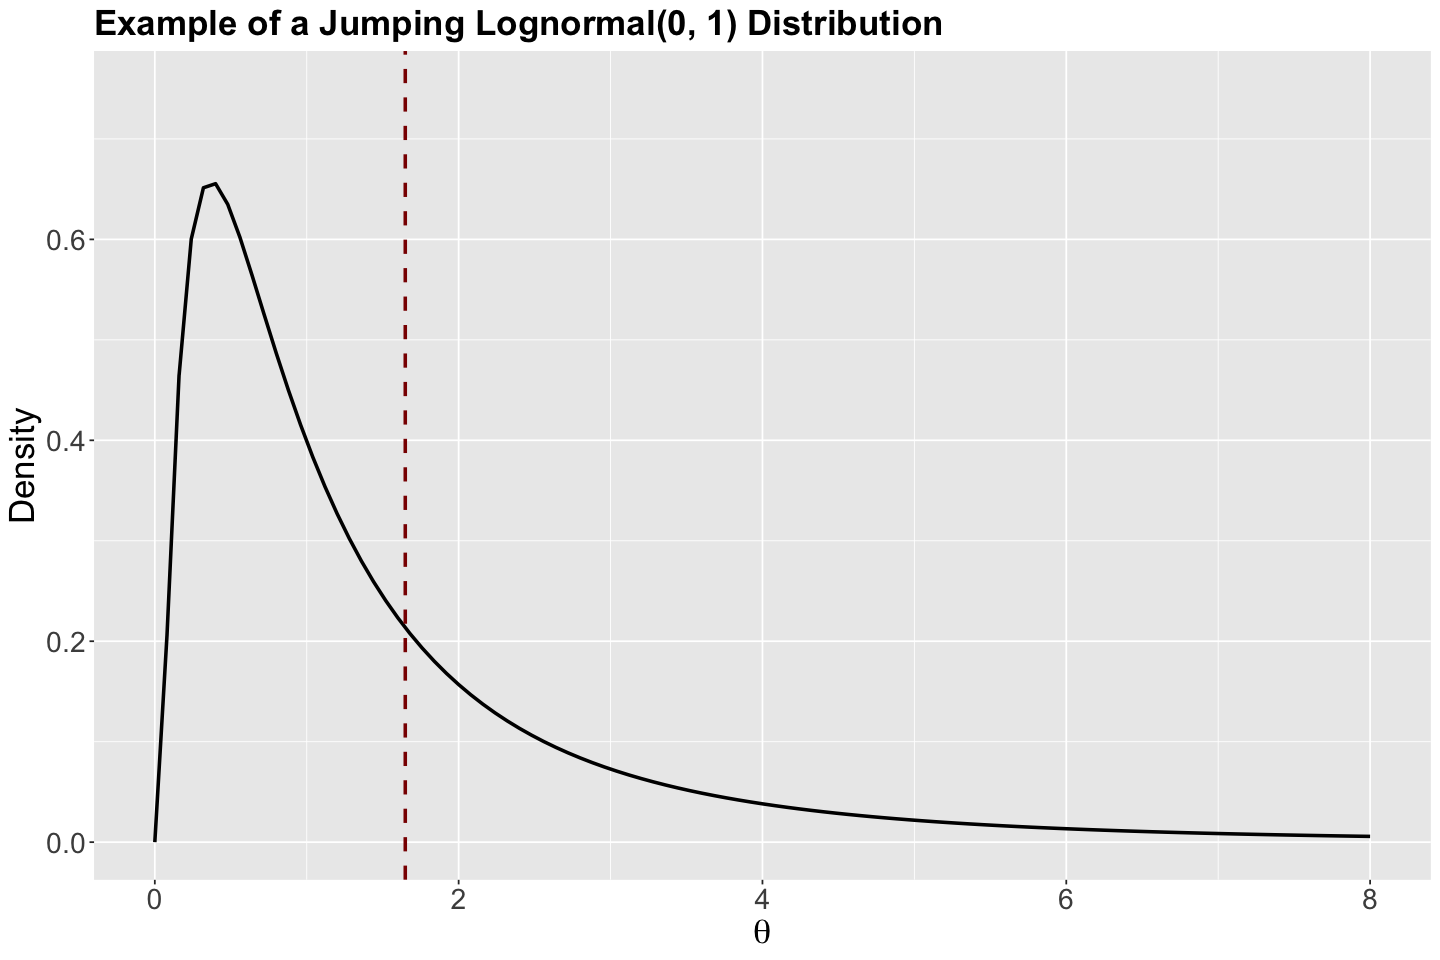

In [10]:
lognormal

- **Step 2.** Now, let us decide to go or not to go to the proposed $\Theta'$:
    
    a. Compute the acceptance probability for $\Theta'$:
    
    $$\alpha = \min \bigg\{ 1, \frac{f(\Theta') \mathscr{l}(\Theta' \mid \mathbf{y})}{f(\Theta) \mathscr{l}(\Theta \mid \mathbf{y})} \times \frac{q(\Theta \mid \Theta')}{q(\Theta' \mid \Theta)} \bigg\}.$$
    
    b. Obtain the next location $\Theta_{i + 1}$ as a Bernoulli trial (**flipping an unfair coin!**) taking on the two possible values:    
    
$$
\Theta_{i + 1} =
\begin{cases}
\Theta' \; \; \; \; \mbox{with probability } \alpha\\
\Theta \; \; \; \; \mbox{with probability } 1 -\alpha.
\end{cases}
$$

**Going back to our belted kingfishers example**, using our Poisson `observed_evidence`, along with the prior

$$\lambda \sim \text{Gamma}(s = 150, r = 40),$$

let us implement the Metropolis algorithm **to obtain an approximate posterior distribution for**

$$\Theta = \lambda,$$

i.e., we have $d = 1$ parameter.

**How does the jumping Uniform distribution work in this case?**

Let us start with the Bayes' rule:

```{math}
\begin{align*}
\overbrace{f(\lambda)}^{\text{Prior}} \times \overbrace{\mathscr{l}(\lambda \mid \mathbf{y})}^{\text{Likelihood}} &= \underbrace{\frac{r^s}{\Gamma(s)} \lambda^{s - 1} \exp(-r \lambda)}_{\text{Prior}} \times \underbrace{\frac{\lambda^{\sum_{i = 1}^n y_i} \exp(-n\lambda)}{\prod_{i = 1}^n y_i!}}_{\text{Likelihood}} \\
&= \frac{40^{150}}{\Gamma(150)} \lambda^{150 - 1} \exp(-40 \lambda) \times \frac{\lambda^{396} \exp(-94\lambda)}{\prod_{i = 1}^n y_i!}
\end{align*}
```

with $\prod_{i = 1}^n y_i!$ being equal to

In [11]:
prod(factorial(observed_evidence$count))

[1] 4.702622e+195

Then, below, we plot 

$$f(\lambda) \times \mathscr{l}(\lambda \mid \mathbf{y}).$$

In [12]:
bayes_rule_lambda_plot <- ggplot() + 
  geom_function(fun = function(x) dgamma(x, shape = 150, rate = 40) * 
    prod(dpois(x = observed_evidence$count, lambda = x))) +
  theme(
    plot.title = element_text(size = 21, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
  ) +
  labs(y = expression(paste("f(", lambda, ") x ", "l(", lambda, "| y)")), x = expression(lambda)) +
  ggtitle("Prior x Likelihood using Bird Counts") +
  scale_x_continuous(breaks = seq(0, 10, 2), limits = c(0, 10))

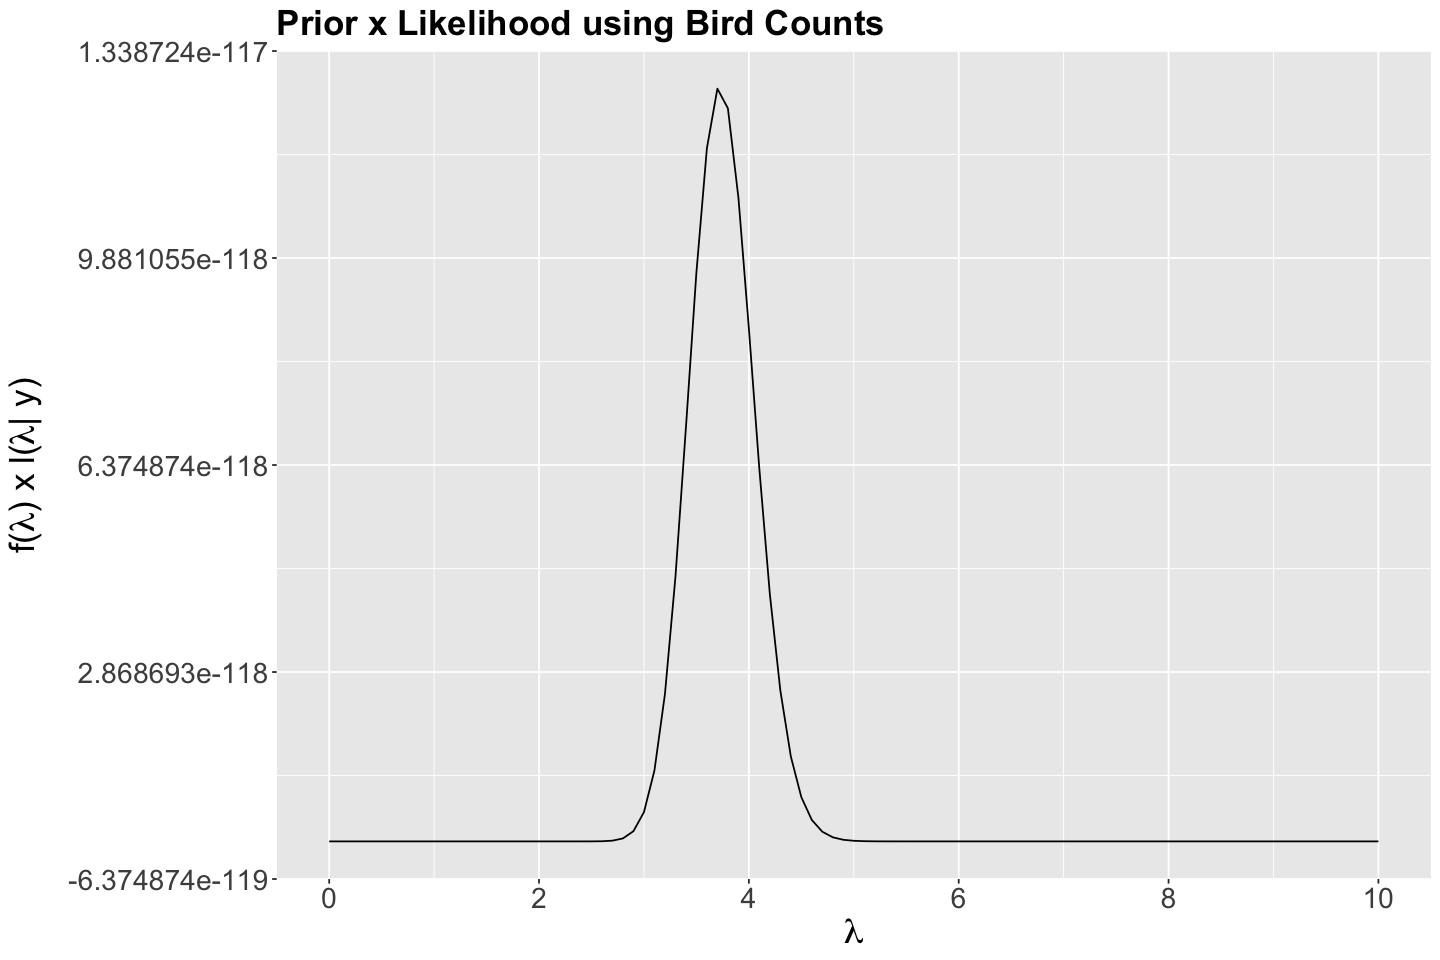

In [13]:
bayes_rule_lambda_plot 

Then, suppose the chain's current state is $\Theta = \lambda = 4$ (dashed vertical blue line in the following plot). In **step 1** of the algorithm, we would randomly choose the proposal $\lambda'$ within the neighbourhood of a jumping $\text{Uniform}(3.5, 4.5)$ distribution with window $w = 0.5$ (whose bounds are plotted as dashed vertical orange lines in the following plot).

In [14]:
bayes_rule_lambda_plot <- bayes_rule_lambda_plot + 
  geom_vline(xintercept = 4, colour = "blue", linetype = "dashed", linewidth = 1) + 
  geom_vline(xintercept = 3.5, colour = "orange", linetype = "dashed", linewidth = 1) + 
  geom_vline(xintercept = 4.5, colour = "orange", linetype = "dashed", linewidth = 1) +
  scale_x_continuous(breaks = c(0, 2, 3.5, 4, 4.5, 6, 8, 10), limits = c(0, 10))

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


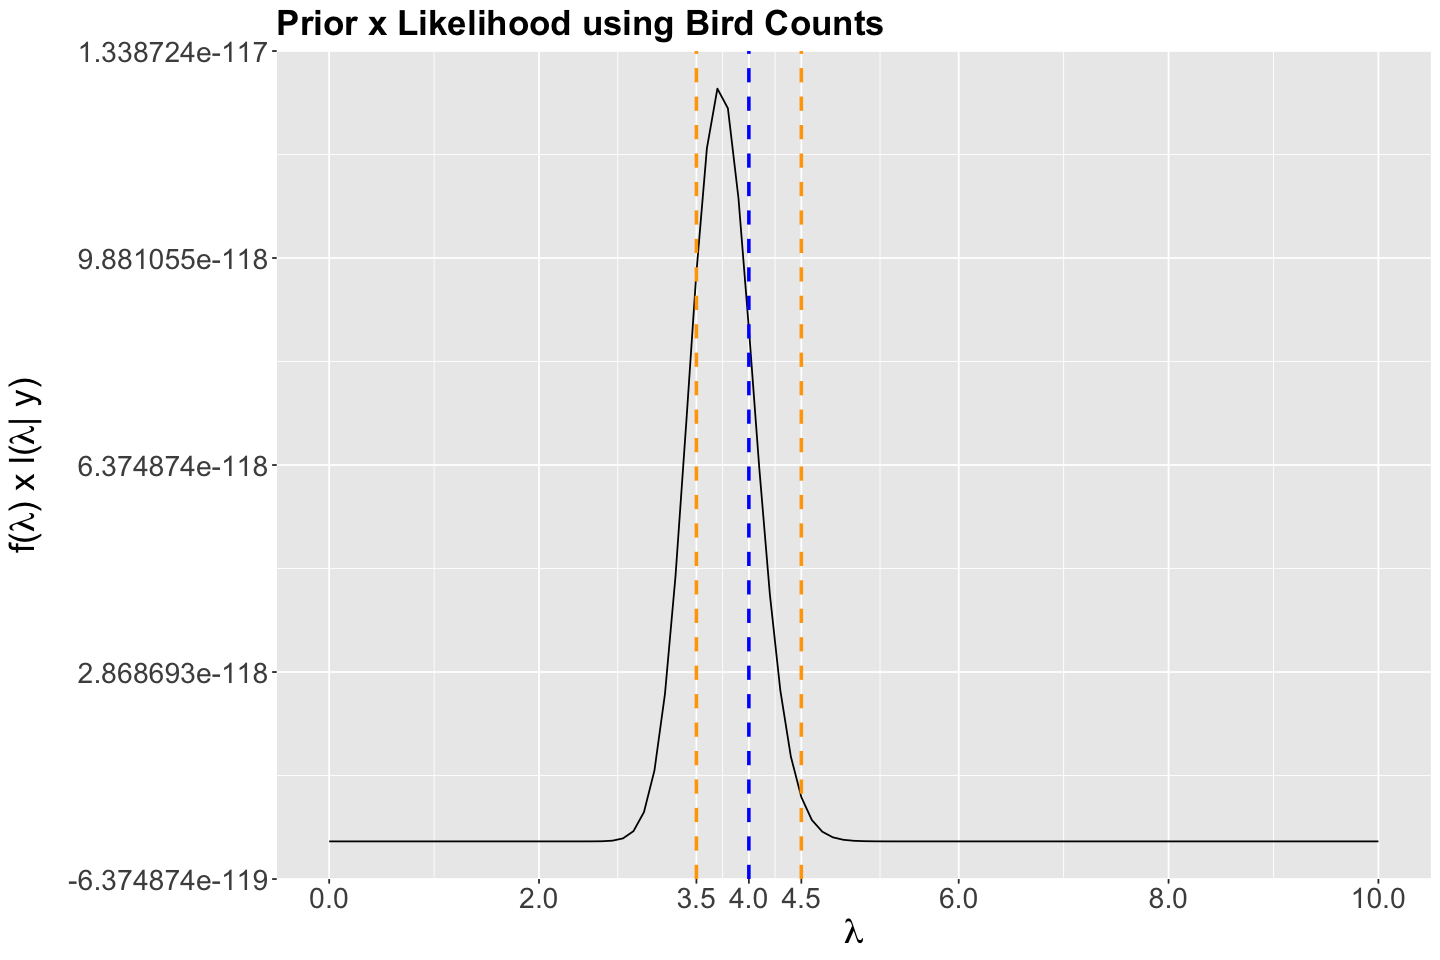

In [15]:
bayes_rule_lambda_plot

## 3. `R` Coding via Metropolis Algorithm

The previous Metropolis-Hastings algorithm can be simplified when the PDF of the jumping distribution is symmetric such as the Uniform:

```{math}
\begin{equation*}
q(\Theta' \mid \Theta) = q(\Theta \mid \Theta') =
\begin{cases}
\frac{1}{2w} \; \; \; \; \mbox{when $\Theta$ and $\Theta'$ are within $w$ units of each other} \\
0 \; \; \; \; 	\mbox{otherwise.}
\end{cases}
\end{equation*}
```

The definition of $\alpha$ in **step 2** will change to:

$$\alpha = \min \bigg\{ 1, \frac{f(\Theta') \mathscr{l}(\Theta' \mid \mathbf{y})}{f(\Theta) \mathscr{l}(\Theta \mid \mathbf{y})} \bigg\}.$$

If $\frac{f(\Theta') \mathscr{l}(\Theta' \mid \mathbf{y})}{f(\Theta) \mathscr{l}(\Theta \mid \mathbf{y})} \geq 1$, then the posterior plausability of $\Theta'$ is as large as that of $\Theta$:

$$\frac{f(\Theta' \mid \mathbf{y})}{f(\Theta \mid \mathbf{y})} \propto \frac{f(\Theta') \mathscr{l}(\Theta' \mid \mathbf{y})}{f(\Theta) \mathscr{l}(\Theta \mid \mathbf{y})} \geq 1.$$

Yielding $\alpha = 1$, **so we WILL ALWAYS move to $\Theta'$**.

If $\frac{f(\Theta') \mathscr{l}(\Theta' \mid \mathbf{y})}{f(\Theta) \mathscr{l}(\Theta \mid \mathbf{y})} < 1$, then the posterior plausability of $\Theta'$ is less than that of $\Theta$:

$$\frac{f(\Theta' \mid \mathbf{y})}{f(\Theta \mid \mathbf{y})} \propto \frac{f(\Theta') \mathscr{l}(\Theta' \mid \mathbf{y})}{f(\Theta) \mathscr{l}(\Theta \mid \mathbf{y})} < 1.$$

Yieding $\alpha = \frac{f(\Theta') \mathscr{l}(\Theta' \mid \mathbf{y})}{f(\Theta) \mathscr{l}(\Theta \mid \mathbf{y})}$, **so we MIGHT move to $\Theta'$ according to our Bernoulli trial**.

Function `one_m_iteration()` implements the previous two steps. Note it has parameters `w` as the window and `current_lambda` as the current state in the Markov chain. Moreover, function `dgamma()` will depict the **Gamma prior** for $\lambda$ and `dpois()` computes the corresponding **Poisson likelihood**. 

This function returns the `proposal_lambda`, the `alpha` probability, and the result of the Bernoulli trial.

```{important}
The upcoming code is **partially** based on the one you can find in [section 7.2 The Metropolis-Hastings algorithm](https://www.bayesrulesbook.com/chapter-7.html#the-metropolis-hastings-algorithm) from the textbook.
```

In [16]:
one_m_iteration <- function(w, current_lambda){
    
 # STEP 1: Randomly drawing a new lambda given a window w
    
 proposal_lambda <- runif(n = 1, min = current_lambda - w, max = current_lambda + w)
  
 # STEP 2: Decide whether or not to go to the proposal_lambda
    
 proposal_plausible <- dgamma(proposal_lambda, shape = 150, rate = 40) * 
    prod(dpois(x = observed_evidence$count, lambda = proposal_lambda))
    
 current_plausisble  <- dgamma(current_lambda, shape = 150, rate = 40) * 
    prod(dpois(x = observed_evidence$count, lambda = current_lambda))
    
 alpha <- min(1, proposal_plausible / current_plausisble)
    
 next_stop <- sample(c(proposal_lambda, current_lambda), size = 1, prob = c(alpha, 1 - alpha))
  
 # Return the results
 return(data.frame(proposal_lambda, alpha, next_stop))
}

Function `m_tour()` executes the corresponding random walk to find the **Markov chain links**. Its parameters are `N` (the number of posterior samples to look for), window `w`, and the initial search value as `current`.

In [17]:
m_tour <- function(N, w, current){
  # 1. Initialize the simulation
  lambda <- rep(0, N)
  alpha <- rep(0, N)

  # 2. Simulate N Markov chain stops
  for(i in 1:N){    
    # Simulate one iteration
    sim <- one_m_iteration(w = w, current_lambda = current)
      
    # Record alpha
    alpha[i] <- sim$alpha
    
    # Record next location
    lambda[i] <- sim$next_stop
    
    # Reset the current location
    current <- sim$next_stop
  }
  
  # 3. Return the chain locations
  return(data.frame(iteration = c(1:N), lambda, alpha))
}

Finally, let us run the MCMC simulation via the Metropolis algorithm.

In [18]:
set.seed(553)
m_simulation <- m_tour(N = 10000, w = 0.5, current = 0.8)

In [19]:
m_simulation

iteration,lambda,alpha
<int>,<dbl>,<dbl>
1,0.8474579,1.000000e+00
2,1.1703387,1.000000e+00
3,1.1703387,1.147450e-14
4,1.1703387,3.290888e-25
5,1.1703387,7.930903e-42
6,1.1703387,0.000000e+00
7,1.5088045,1.000000e+00
8,1.6950139,1.000000e+00
⋮,⋮,⋮


Assume we use a `thin` setup (as in `sampling()` from `Stan`) of `3`:

In [20]:
m_simulation <- m_simulation |> 
  filter(row_number() %% 4 == 1)
m_simulation

iteration,lambda,alpha
<int>,<dbl>,<dbl>
1,0.8474579,1.000000e+00
5,1.1703387,7.930903e-42
9,1.6950139,1.972020e-12
13,2.1820057,1.187154e-01
17,2.8358935,1.000000e+00
21,3.7587235,1.000000e+00
25,3.7606601,4.622410e-04
29,3.8581526,4.842129e-01
⋮,⋮,⋮


Then, as a warmup, we discard the first `500` samples:

In [21]:
m_simulation <- tail(m_simulation, n = 2000)
m_simulation

,iteration,lambda,alpha
,<int>,<dbl>,<dbl>
501,2001,4.037586,1.000000000
502,2005,4.018275,0.210024892
503,2009,4.036120,1.000000000
504,2013,4.022553,0.249865024
505,2017,3.802944,0.002439906
506,2021,3.903436,0.014862101
507,2025,4.081944,0.089770076
508,2029,4.285217,0.372838339
⋮,⋮,⋮,⋮


Let us check whether our approximate posterior samples matched the previously obtained exact Gamma posterior for $\lambda$. We can see our simulation results are, in fact, coming from this Gamma posterior.

In [22]:
gamma_poisson_birds <- gamma_poisson_birds +
  geom_histogram(
    data = m_simulation,
    aes(x = lambda, y = after_stat(density)), fill = "lightgreen",
    color = "black", bins = 25, alpha = 0.2
  )

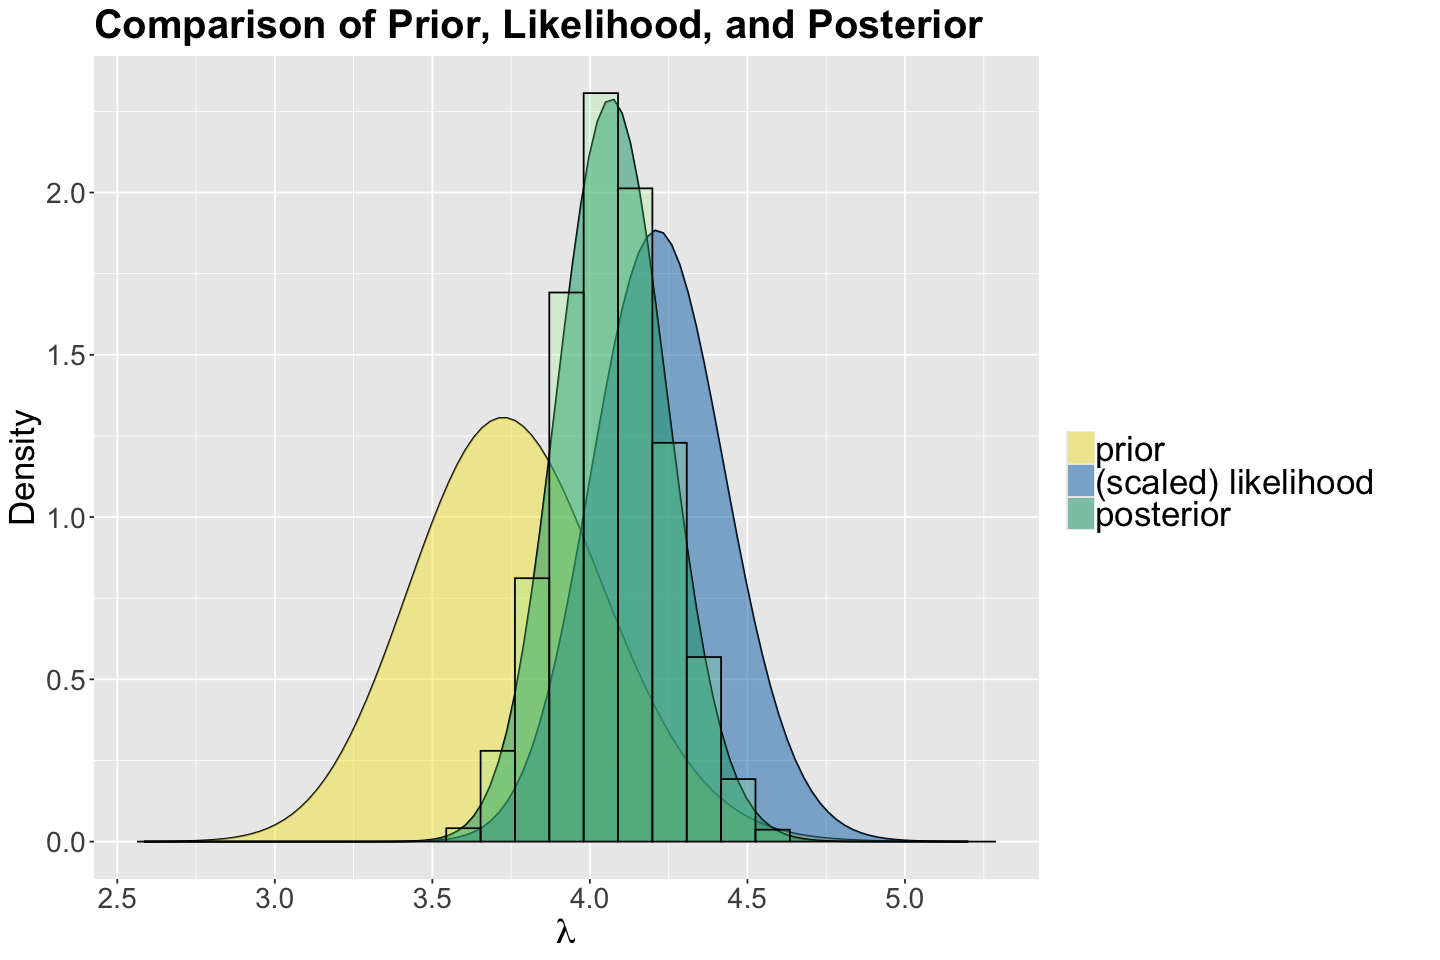

In [23]:
gamma_poisson_birds

## 4. Wrapping Up 

- Metropolis-Hastings and its simplified Metropolis version are only a couple of MCMC tools.
- These two approaches target single parameters (e.g., a probability of success $p$ or a mean $\mu$). However, when we want to deal with $d$ parameters, such as $\Theta = (\theta_1, \dots, \theta_d)^T$, there are more efficient tools like **Gibbs sampling** (used in [JAGS, Just Another Gibbs Sampler](https://mcmc-jags.sourceforge.io)) or **Hamiltonian Monte Carlo (HMC)** algorithm (used in [`Stan`](https://mc-stan.org/docs/reference-manual/hamiltonian-monte-carlo.html)). 